In [1]:
import numpy as np
import cft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections
from scipy.spatial import ConvexHull

In [2]:
plt.rcParams['figure.figsize'] = (15, 10)

xlim = [-20, 20]
ylim = [-20, 20]

def plot_image(box, data, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.imshow(data, extent=[-box.L/2, box.L/2, -box.L/2, box.L/2], interpolation='nearest', cmap='RdYlBu')
    plt.show()

# Adhesion

First we need initial conditions. These are generated using the `cft` module, which can also compute ICs using constraints. But we won't use that here. Here we only do 2D computations; however, the method is completely generic. So 3D (besides performance issues) should not be problem.

We first define a `Box` with the desired dimensions. This class takes the number of dimensions, number of pixels in each dimension and the physical length as parameters.

In [3]:
box = cft.Box(dim=2, N=128, L=100.)

Next, a powerspectrum. In this case $P(k) = k^n$ with $n = -1$ and an additional Gaussian smoothing factor with $\sigma = 1.0$.

In [4]:
P = cft.Power_law(n=-0.75) * cft.Scale(box, 0.5)

Now we can create a Gaussian random field. We normalize on the density by deviding by the standard deviation. This ensures that the first structures collapse at about $t = 1$.

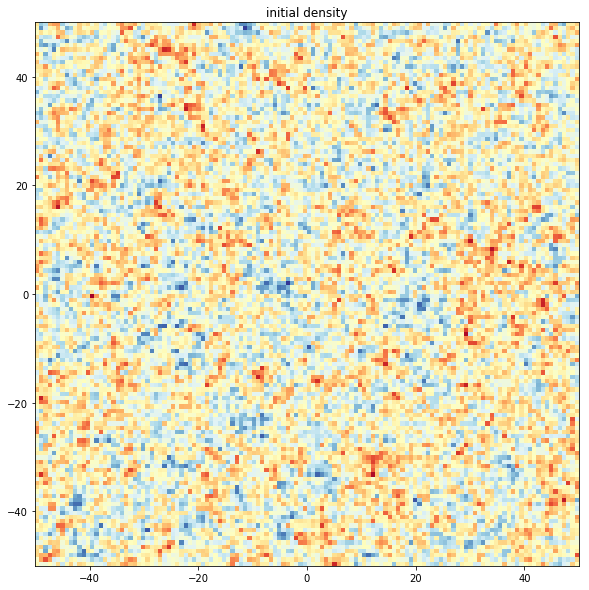

In [5]:
delta_0 = cft.garfield(B=box, P=P, seed=44)
delta_0 /= delta_0.std()
plot_image(box, delta_0, "initial density")

### Computing the potential

Next, to compute the potential, we use Fourier integration of Poissons equation:
$$-k^2 \hat{\Phi}(k) = \hat{\delta}_0(k)$$

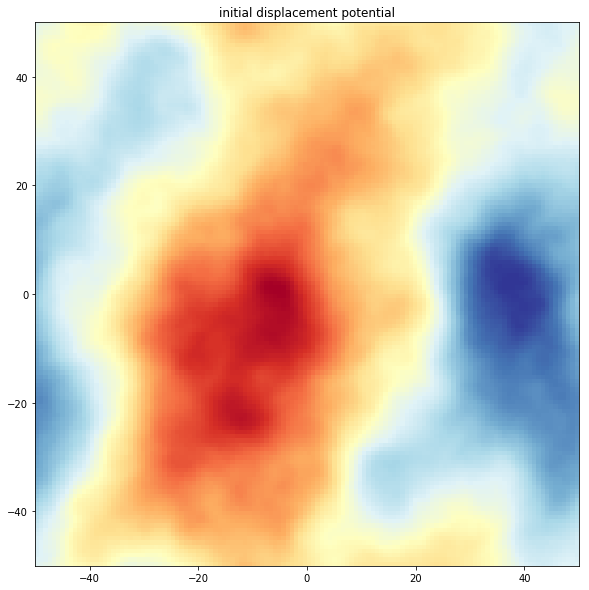

In [6]:
pot_0 = np.fft.ifftn(np.fft.fftn(delta_0) * cft.Potential()(box.K)).real
plot_image(box, pot_0, "initial displacement potential")

### Create points for convex hull computation
Now, to compute the adhesion approximation, we need to lift the grid points to a parabola, adding the displacement potential as a weight.
$$q_z = q^2 - 2 t \Phi(q)$$

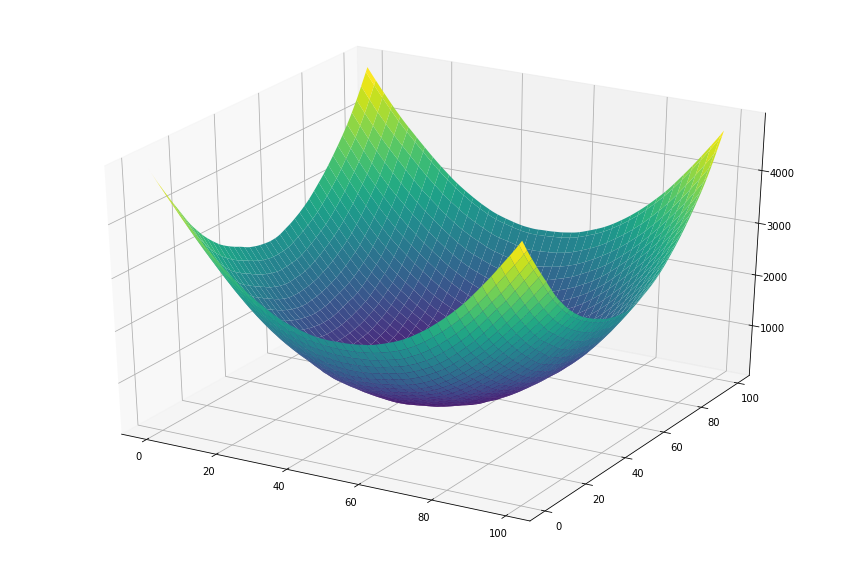

In [7]:
q = np.indices(box.shape) * box.L/box.N
z = np.sum((q-box.L/2)**2, axis=0) - 2 * 2.0 * pot_0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(q[0], q[1], z, cmap='viridis')
plt.show()

To compute the adhesion model we need just the points without the grid structure. We could have sampled the potential at any collection of points. For instance using a glass distribution. In this case we simply reshape the array that is shown above.

In [8]:
def lagrangian_vertices(box, pot, t):
    q = np.indices(box.shape) * box.L/box.N - box.L/2
    z = np.sum(q**2, axis=0) - 2 * t * pot
    return np.concatenate([q, np.expand_dims(z, 0)], 0).reshape(box.dim+1, -1).T

In [9]:
pts = lagrangian_vertices(box, pot_0, 2.0)

### Compute the convex hull

At the core of the adhesion model lies the computation of the Regular triangulation. We compute the regular triangulation by means of a convex hull.

In [10]:
ch = ConvexHull(pts)

As you can see from the next plot, we also get some triangles that are irrelevant to our purpose. We get rid of those by selecting only triangles with a normal with a positive downward vector component.

In [11]:
selection = np.where(np.dot(ch.equations[:,0:3], [0, 0, -1]) > 0.00001)[0]
valid = selection[np.where(np.all(np.isin(ch.neighbors[selection], selection), axis=1))[0]]

Now, what we get is a set of triangles on the input set of vertices. The next plot is a direct (but flattened) representation of the convex hull.

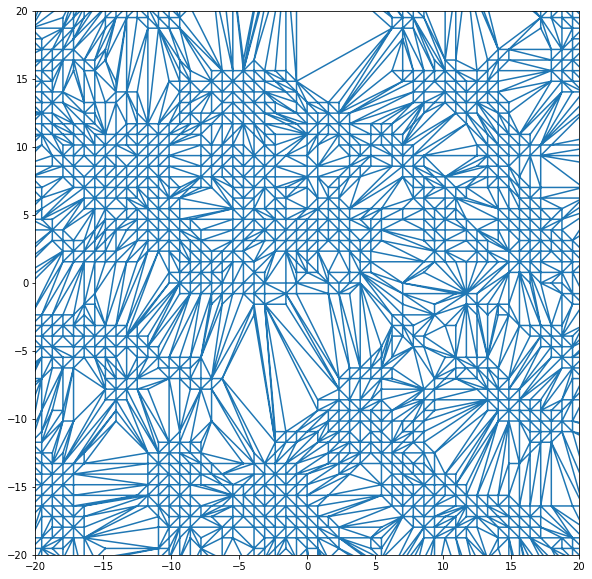

In [12]:
def plot_regular_triangulation(ch, selection, xlim=None, ylim=None):
    x = ch.points[:,0]
    y = ch.points[:,1]
    t = ch.simplices[selection]


    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.triplot(x, y, t)
    plt.show()

plot_regular_triangulation(ch, selection, xlim, ylim)

### Plotting the dual Voronoi diagram

Dual to the delaunay triangulation is the _Voronoi diagram_. We can get at the the Voronoi diagram by evaluating the plane equations that describe the convex hull. The normal vector to the planes in the convex hull have three components, of which one is the dimension of the potential (i.e. $q^2 - 2t\Phi$). This dimension is denoted with the unit vector $\hat{\phi}$. The $x$ coordinate of a particle (i.e. a node in the power diagram) is given by the relation:
$$\vec{x} = -\frac{\vec{n}_{x \dots}}{2 n_{\phi}}$$
The mass of each particle is given by the area of its dual Delaunay face.

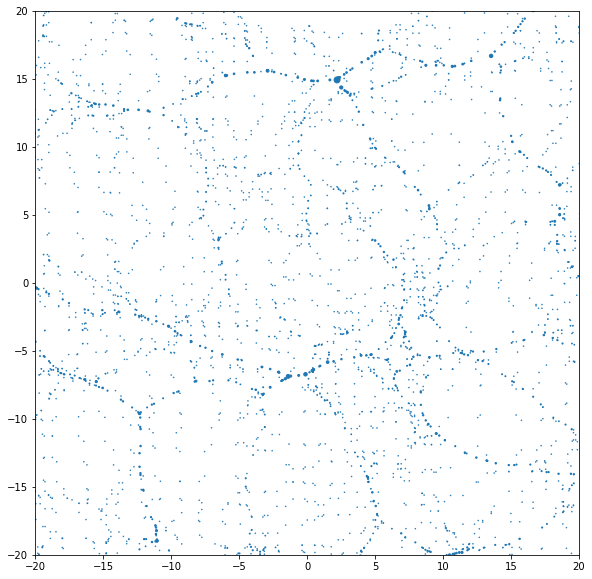

In [13]:
def delaunay_areas(ch, selection):
    a, b, c = ch.points[ch.simplices[selection]][:,:,:box.dim].transpose([1,0,2])
    return np.abs(np.cross(a - b, c - b) / 2)

def voronoi_points(ch, selection):
    return - ch.equations[selection][:,:2] / ch.equations[selection][:,2][:,None] / 2

def plot_voronoi_points(ch, selection, xlim=None, ylim=None):
    X = voronoi_points(ch, selection)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.scatter(X[:,0], X[:,1], s=delaunay_areas(ch, selection))
    plt.show()

plot_voronoi_points(ch, valid, xlim, ylim)

The triangulation data that we get from computing the the convex hull also gives us information on the connectivity between particles. We use this connectivity to plot filaments. First we need to extract all relevant edges. Edges lie between neighbouring faces. In the following function we take each pair of neighbouring faces. We ask for unique results to get rid of double entries.

In [14]:
def edges(ch, valid):
    nb = np.zeros(shape=(len(valid), 2*(box.dim+1)), dtype=int)
    nb[:,1::2] = ch.neighbors[valid]  # neighbours index into simplices and equations
    nb[:,0::2] = valid[:,None]        # so does `valid`, we intersperse them to create pairs
    return np.unique(np.sort(nb.reshape([-1, 2]), axis=1), axis=0)

In [15]:
def edge_points(ch, edges):
    save = np.seterr(invalid = 'ignore', divide = 'ignore')
    pts = - ch.equations[:,:2] / ch.equations[:,2][:,None] / 2
    np.seterr(**save)
    return pts[edges]

Next, to compute the length of each edge, we first find the vertices common to the neighbouring faces.

In [16]:
def edge_length(ch, edges):
    # find the points common to both simplices, should always be two points
    # this operation performs a loop in Python TODO: find numpy expression
    edge_verts = np.array([np.intersect1d(x[0], x[1]) for x in ch.simplices[edges]])
    return np.sqrt(np.sum((ch.points[edge_verts][:,1,:2] - ch.points[edge_verts][:,0,:2])**2, axis=1))

In [17]:
m_edges = edges(ch, valid)
m_edge_lengths = edge_length(ch, m_edges)
m_edge_points = edge_points(ch, m_edges)

edge_sel = np.where(m_edge_lengths > np.sqrt(2)*box.res)[0]

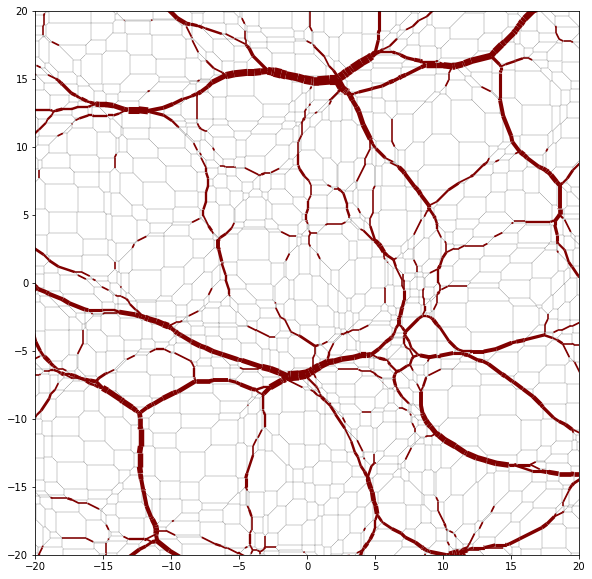

In [18]:
lc_grid = collections.LineCollection(m_edge_points, linewidths=0.2, color='black')
lc = collections.LineCollection(m_edge_points[edge_sel], linewidths=m_edge_lengths[edge_sel], color='maroon')

X = voronoi_points(ch, valid)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.add_collection(lc_grid)
ax.add_collection(lc)
ax.set_aspect('equal')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.scatter(X[:,0], X[:,1], s=delaunay_areas(ch, valid)**1.5)
plt.show()